# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
np.random.seed(1337)
from keras import Sequential
from keras.utils import Sequence
from keras.layers import LSTM, Dense, Masking
import numpy as np
import keras
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
import datetime
from datetime import datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
import tensorflow as tf
import tensorflow_hub as hub

# Loading The Data

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Mar 15 14:56:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install transformers
!pip install spacy 
!pip install sentencepiece

     |████████████████████████████████| 1.9MB 5.3MB/s 
     |████████████████████████████████| 890kB 26.9MB/s 
     |████████████████████████████████| 3.2MB 34.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=a9fc9ce79c74e698dab2582826382107f3e0fb0849ece79a3539f4ea441b1b86
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 1.2MB 6.6MB/s 


In [5]:
import numpy as np
import pandas as pd
import fnmatch
import os
import random
import re
import threading
import librosa,librosa.display
import tensorflow as tf
from six.moves import xrange
import time
import json
import torch as t
import tqdm
import soundfile
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.distributed import DistributedSampler
from time import sleep
import torch.nn as nn
import torch.nn.functional as F
import math
import pickle
import functools
import sentencepiece

In [6]:
work_dir = '/content/drive/My Drive/Inter-IIT/'
article_path = '/content/drive/My Drive/Inter-IIT/Development Data/dev_data_article.xlsx'
#tweet_path = '/content/drive/My Drive/Inter-IIT/Development Data/dev_data_tweet.xlsx'
tweet_path = '/content/drive/My Drive/Inter-IIT/Development Data/q1.csv'

In [7]:
train_raw = pd.DataFrame(pd.read_excel(article_path)) 

In [8]:
#train_raw = pd.read_csv(article_path)
train_raw.head()

,Text_ID,Text,Headline,Mobile_Tech_Flag
0,article_0001,Digitisation is one of the key buzzwords in th...,Pakistan’s digital landscape post-Covid,0
1,article_0002,Increase in tolerance limit up to 120 per cent...,Affordable housing gets shot in the arm,0
2,article_0003,Home > News > World Sports News\n\nJonas Lossl...,Jonas Lossl leaves Everton to rejoin first clu...,0
3,article_0004,"Source: Agfax.com\n\nBy Keith Brown, DTN Contr...",DTN Cotton Closing: Cotton Higher on Commoditi...,0
4,article_0005,"United Nations, Feb 4: The Serum Institute of ...","Serum Institute of India, UNICEF enter into lo...",0


In [9]:
train_raw = train_raw[['Text','Mobile_Tech_Flag']]

In [10]:
#train_raw = pd.read_csv(article_path)
train_raw.head()

,Text,Mobile_Tech_Flag
0,Digitisation is one of the key buzzwords in th...,0
1,Increase in tolerance limit up to 120 per cent...,0
2,Home > News > World Sports News\n\nJonas Lossl...,0
3,"Source: Agfax.com\n\nBy Keith Brown, DTN Contr...",0
4,"United Nations, Feb 4: The Serum Institute of ...",0


In [11]:
train_raw.shape

(4000, 2)

## Concatenating tweets

In [12]:
df_tweet = pd.read_csv(tweet_path)

In [13]:
df_tweet = df_tweet.drop(['Tweet_ID'],axis = 1)

In [14]:
df_tweet['Mobile_Tech_Tag'].value_counts()             #Counting the labels 

0    3000
1    1000
Name: Mobile_Tech_Tag, dtype: int64

In [15]:
df_tweet.rename(columns={'Tweet':'Text','Mobile_Tech_Tag': 'Mobile_Tech_Flag'})

,Text,Mobile_Tech_Flag
0,You'll 💜 my #PitchWars book if you like: 🦋 hat...,0
1,@SkySportsNews: 🚨 Breaking: #WBA have reached ...,0
2,@stealyoman_cuso: really says a lot about soci...,0
3,@PGtzsche1: HPV vaccines increased serious ner...,0
4,Ramaphosa says if you are positive you must se...,0
...,...,...
3995,@ZeeNews: चीनी मोबाइल कंपनी रियलमी ने अपना Rea...,1
3996,@ZeeNews: चीनी मोबाइल कंपनी रियलमी ने अपना Rea...,1
3997,चीनी मोबाइल कंपनी रियलमी ने अपना Realme V15 5G...,1
3998,@AnjaliSingh_IN: Aapne phone hi galat choose K...,1


In [16]:
pd.concat([train_raw,df_tweet.rename(columns={'Tweet':'Text','Mobile_Tech_Tag': 'Mobile_Tech_Flag'})], ignore_index=True)

,Text,Mobile_Tech_Flag
0,Digitisation is one of the key buzzwords in th...,0
1,Increase in tolerance limit up to 120 per cent...,0
2,Home > News > World Sports News\n\nJonas Lossl...,0
3,"Source: Agfax.com\n\nBy Keith Brown, DTN Contr...",0
4,"United Nations, Feb 4: The Serum Institute of ...",0
...,...,...
7995,@ZeeNews: चीनी मोबाइल कंपनी रियलमी ने अपना Rea...,1
7996,@ZeeNews: चीनी मोबाइल कंपनी रियलमी ने अपना Rea...,1
7997,चीनी मोबाइल कंपनी रियलमी ने अपना Realme V15 5G...,1
7998,@AnjaliSingh_IN: Aapne phone hi galat choose K...,1


In [17]:
train_raw = pd.concat([train_raw,df_tweet.rename(columns={'Tweet':'Text','Mobile_Tech_Tag': 'Mobile_Tech_Flag'})], ignore_index=True)

# Preprocessing Data

Select non null:

In [18]:
train_raw = train_raw[train_raw.Text.notnull()]
train_raw.shape

(8000, 2)

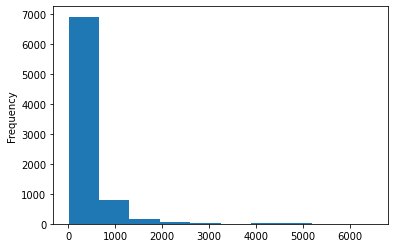

In [19]:
train_raw.Text.apply(lambda x: len(x.split())).plot(kind='hist')

In [20]:
train_raw['len_txt'] =train_raw.Text.apply(lambda x: len(x.split()))
train_raw.describe()

,Mobile_Tech_Flag,len_txt
count,8000.000000,8000.000000
mean,0.246750,299.901500
std,0.431147,529.864237
min,0.000000,3.000000
25%,0.000000,34.000000
50%,0.000000,62.000000
75%,0.000000,400.250000
max,1.000000,6489.000000


In [21]:
train_raw.shape

(8000, 3)

In [22]:
for l in np.unique(train_raw['Mobile_Tech_Flag']):
  print(l)

0
1


In [23]:
train = train_raw.copy()

In [24]:
train = train.reindex(np.random.permutation(train.index))
train.head()

,Text,Mobile_Tech_Flag,len_txt
5901,@Ranjeet16575196 @AmitShah @narendramodi buddy...,0,48
6601,@gauravcsawant: What did India set out to do w...,0,105
7056,@MadhavSheth1: We are the pioneers of 64 MP Sm...,1,46
4280,@AnfieldEditon: Liverpool are hesitant to proc...,0,39
2669,CBSE Single Girl Child Scholarship 2020 Applic...,0,313


Clean the text columns

In [25]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.2, random_state=35)
train.head()

,Text,Mobile_Tech_Flag,len_txt
7854,@YouthExpressIND: यूनिक डिजाइन के साथ बेहतरीन ...,1,16
5811,@abccare Aditya Birla company fraud 8400 se ru...,0,51
1456,Oral health and hygiene market in Ireland is c...,0,1148
768,The World Health Organization has set the reco...,0,713
709,Bismah Malik By\n\nExpress News Service\n\nBEN...,0,434


In [26]:
train.reset_index(drop=True, inplace=True)
train.head(2)

,Text,Mobile_Tech_Flag,len_txt
0,@YouthExpressIND: यूनिक डिजाइन के साथ बेहतरीन ...,1,16
1,@abccare Aditya Birla company fraud 8400 se ru...,0,51


In [27]:
val.reset_index(drop=True, inplace=True)
val.head(2)

,Text,Mobile_Tech_Flag,len_txt
0,नई दिल्ली। भारतीय रिजर्व बैंक ऑफ इंडिया ने अहम...,0,250
1,Ministry of Finance\n\nRevised Issuance Calend...,0,587


In [28]:
val.shape, train.shape

((1600, 3), (6400, 3))

In [29]:
print("Training Set Shape :", train.shape)
print("Validation Set Shape :", val.shape)
# print("Test Set Shape :", test.shape)

Training Set Shape : (6400, 3)
Validation Set Shape : (1600, 3)


In [30]:
DATA_COLUMN = 'Text'
LABEL_COLUMN = 'Mobile_Tech_Flag'
# The list containing all the classes (train['SECTION'].unique())
label_list = [x for x in np.unique(train.Mobile_Tech_Flag)]
label_list

[0, 1]

# Splitting the Data into smaller chunks

In [31]:
def get_split(text1, chunk_len = 200, overlap = 50):
  l_total = []
  l_parcial = []
  if len(text1.split())//(chunk_len-overlap) >0:
    n = len(text1.split())//(chunk_len-overlap)
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:chunk_len]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*(chunk_len - overlap):w*(chunk_len - overlap) + 200]
      l_total.append(" ".join(l_parcial))
  return l_total

In [32]:
train['text_split'] = train[DATA_COLUMN].apply(get_split)
train.head()

,Text,Mobile_Tech_Flag,len_txt,text_split
0,@YouthExpressIND: यूनिक डिजाइन के साथ बेहतरीन ...,1,16,[@YouthExpressIND: यूनिक डिजाइन के साथ बेहतरीन...
1,@abccare Aditya Birla company fraud 8400 se ru...,0,51,[@abccare Aditya Birla company fraud 8400 se r...
2,Oral health and hygiene market in Ireland is c...,0,1148,[Oral health and hygiene market in Ireland is ...
3,The World Health Organization has set the reco...,0,713,[The World Health Organization has set the rec...
4,Bismah Malik By\n\nExpress News Service\n\nBEN...,0,434,[Bismah Malik By Express News Service BENGALUR...


In [33]:
len(train['text_split'][0])

1

In [34]:
val['text_split'] = val[DATA_COLUMN].apply(get_split)
val.head(2)

,Text,Mobile_Tech_Flag,len_txt,text_split
0,नई दिल्ली। भारतीय रिजर्व बैंक ऑफ इंडिया ने अहम...,0,250,[नई दिल्ली। भारतीय रिजर्व बैंक ऑफ इंडिया ने अह...
1,Ministry of Finance\n\nRevised Issuance Calend...,0,587,[Ministry of Finance Revised Issuance Calendar...


In [35]:
len(train['Text'][0])

139

In [36]:
len(train['text_split'][0])

1

In [37]:
train_l = []
label_l = []
index_l =[]
for idx,row in train.iterrows():
  for l in row['text_split']:
    train_l.append(l)
    label_l.append(row['Mobile_Tech_Flag'])
    index_l.append(idx)
len(train_l), len(label_l), len(index_l)

(14141, 14141, 14141)

In [38]:
val_l = []
val_label_l = []
val_index_l = []
for idx,row in val.iterrows():
  for l in row['text_split']:
    val_l.append(l)
    val_label_l.append(row['Mobile_Tech_Flag'])
    val_index_l.append(idx)
len(val_l), len(val_label_l), len(val_index_l)

(3507, 3507, 3507)

The final dataset for training:

In [39]:
train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
train_df.head()

,Text,Mobile_Tech_Flag
0,@YouthExpressIND: यूनिक डिजाइन के साथ बेहतरीन ...,1
1,@abccare Aditya Birla company fraud 8400 se ru...,0
2,Oral health and hygiene market in Ireland is c...,0
3,assess Irish consumers’ current dental care ha...,0
4,will significantly reduce the chances of bigge...,0


In [40]:
val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
val_df.head()

,Text,Mobile_Tech_Flag
0,नई दिल्ली। भारतीय रिजर्व बैंक ऑफ इंडिया ने अहम...,0
1,Ministry of Finance Revised Issuance Calendar ...,0
2,"₹5,000 crore iii) 14 Year for ₹11,000 crore iv...",0
3,"March 22-26, 2021 20,000 i) FRB ₹4,000 crore i...",0
4,@BJP4MP @vdsharmabjp @ChouhanShivraj @nstomar ...,1


# XLMR: Data Preprocessing 

In [41]:
from transformers import XLMRobertaTokenizer

tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

In [42]:
all_tokens = list(tokenizer.get_vocab().keys())
print(f'This is a vocab of {len(all_tokens)} tokens')

This is a vocab of 250002 tokens


In [43]:
print(tokenizer)

PreTrainedTokenizer(name_or_path='xlm-roberta-base', vocab_size=250002, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})


In [44]:
with open("/content/sample_data/vocab.txt", "w") as f:
   for token in all_tokens:
       f.write(token + '\n')

In [45]:
train_df.values.shape

(14141, 2)

In [46]:
val_df.values.shape

(3507, 2)

In [47]:
pd.concat([train_df, val_df]).values.shape

(17648, 2)

In [48]:
df_art = pd.concat([train_df, val_df])

In [49]:
# Retrive the first article 

text = df_art.iloc[1].Text
tokens = tokenizer.tokenize(text)

print(f'No of tokens in this article : {len(tokens)}')

print(text)

No of tokens in this article : 89
@abccare Aditya Birla company fraud 8400 se rupaye mujhse lekar loan approval abhi tak nahin kiya ek Mahina Ho Gaya kisi Garib ka Paisa loot Hain kripya Sarkar se nivedan hai Aditya Birla company ko band karaya jaaye seal kar diya jaaye aur media wale bhi sunte nahin music YouTube https://t.co/XxfsghWgj5


In [50]:
print('First 512 tokens : ')
print(tokens[:512])

First 512 tokens : 
['▁@', 'ab', 'cca', 're', '▁Adi', 'tya', '▁Bir', 'la', '▁company', '▁fraud', '▁8', '400', '▁se', '▁rupa', 'ye', '▁mujh', 'se', '▁lekar', '▁loan', '▁appro', 'val', '▁a', 'bhi', '▁tak', '▁na', 'hin', '▁kiya', '▁ek', '▁Mah', 'ina', '▁Ho', '▁Gaya', '▁kisi', '▁Gar', 'ib', '▁ka', '▁Pais', 'a', '▁loo', 't', '▁Hain', '▁', 'krip', 'ya', '▁Sarkar', '▁se', '▁ni', 've', 'dan', '▁hai', '▁Adi', 'tya', '▁Bir', 'la', '▁company', '▁ko', '▁band', '▁kara', 'ya', '▁ja', 'aye', '▁seal', '▁kar', '▁diya', '▁ja', 'aye', '▁aur', '▁media', '▁wale', '▁bhi', '▁sunt', 'e', '▁na', 'hin', '▁music', '▁YouTube', '▁https', '://', 't', '.', 'co', '/', 'X', 'x', 'fs', 'gh', 'W', 'gj', '5']


In [51]:
# Main Tokenization here 
input_ids = []
lengths = []

print('Tokenizing comments.....')

for sen in df_art.Text:

    if(len(input_ids) % 1000 == 0):
      print(f'Read about {len(input_ids)} article!')
    

    encoded_sent = tokenizer.encode(
                            sen,
                            # max_length = 512,
                            # return_tensors = 'pt'   
                            )
    
    input_ids.append(encoded_sent)
    lengths.append(len(encoded_sent))

print('Done!')

Tokenizing comments.....
Read about 0 article!


Token indices sequence length is longer than the specified maximum sequence length for this model (1073 > 512). Running this sequence through the model will result in indexing errors


Read about 1000 article!
Read about 2000 article!
Read about 3000 article!
Read about 4000 article!
Read about 5000 article!
Read about 6000 article!
Read about 7000 article!
Read about 8000 article!
Read about 9000 article!
Read about 10000 article!
Read about 11000 article!
Read about 12000 article!
Read about 13000 article!
Read about 14000 article!
Read about 15000 article!
Read about 16000 article!
Read about 17000 article!
Done!


In [52]:
labels = df_art.Mobile_Tech_Flag.to_numpy().astype(int)

print(f'No of mobile_tech labels : {np.sum(labels)}')
print(f'No of non_mobile_tech labels : {len(labels) - np.sum(labels)}')

No of mobile_tech labels : 4351
No of non_mobile_tech labels : 13297


In [53]:
print(f'Min length of tokens : {min(lengths)}')
print(f'Max length of tokens : {max(lengths)}')
print(f'Mean length of tokens : {np.mean(lengths)}')

Min length of tokens : 6
Max length of tokens : 1073
Mean length of tokens : 239.29357434270173


In [54]:
print(f'Min length of tokens : {min(lengths)}')
print(f'Max length of tokens : {max(lengths)}')
print(f'Mean length of tokens : {np.mean(lengths)}')

Min length of tokens : 6
Max length of tokens : 1073
Mean length of tokens : 239.29357434270173


In [55]:
temp = []

for i in lengths:
    if(i > 833):
        temp.append(i)
print(len(temp))

3


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


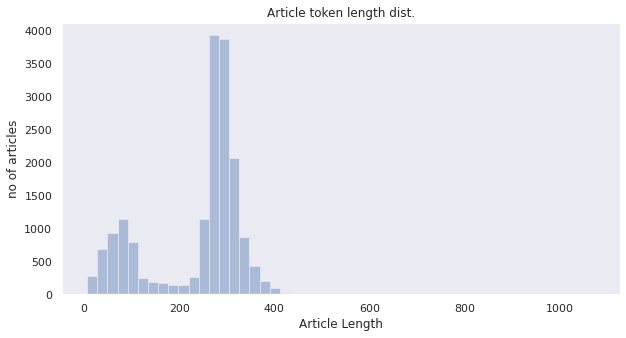

In [56]:
#Plotting the data for knowing distributions of length if tokens!
import seaborn as sns

sns.set(style = 'dark')
plt.rcParams["figure.figsize"] = (10,5)
new_lengths = [min(l,2000) for l in lengths]

sns.distplot(new_lengths,kde=False)

plt.title('Article token length dist.')
plt.xlabel('Article Length')
plt.ylabel('no of articles')
plt.show()

In [57]:
# Truncating to 512 for now (other wise use chunking for giving sentence length)

from keras.preprocessing.sequence import  pad_sequences

MAX_LEN = 512

input_ids = pad_sequences(input_ids, maxlen = MAX_LEN, dtype = "long", value=0, 
                          truncating="post", padding="post")


In [58]:
print(input_ids.shape)

(17648, 512)


In [59]:
# Attention Mask
attention_masks = []

for sent in input_ids:
    # set mask to 0 if token_id is 0 (becoz its padding) and vice versa
    attn_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(attn_mask)


In [60]:
# Now we split the data into 90 percent for training and 10 percent for testing 
from sklearn.model_selection import train_test_split

train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size = 0.1, random_state = 42)
train_masks, val_masks = train_test_split(attention_masks, test_size = 0.1, random_state = 42)


In [61]:
train_inputs = t.tensor(train_inputs)
val_inputs = t.tensor(val_inputs)

train_labels = t.tensor(train_labels )
val_labels = t.tensor(val_labels)

train_masks = t.tensor(train_masks)
val_masks = t.tensor(val_masks)

In [62]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 8

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_loader = DataLoader(train_data, batch_size = batch_size, sampler = train_sampler)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = RandomSampler(val_data)
val_loader = DataLoader(val_data, batch_size = batch_size, sampler = val_sampler)

# XLMR: Loading the pre-trained model

In [63]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")

In [64]:
from transformers import XLMRobertaForSequenceClassification, AdamW, XLMRobertaConfig

model = XLMRobertaForSequenceClassification.from_pretrained(
        "xlm-roberta-base",
        num_labels = 2,
        output_attentions = False,
        output_hidden_states = False,
)

model.cuda()

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

In [67]:
import torch

In [68]:
model.load_state_dict(torch.load('/content/drive/My Drive/Inter-IIT/article(chunked)+tweets_model_8epochs.bin'))

<All keys matched successfully>

In [121]:
# optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

In [122]:
# from transformers import get_linear_schedule_with_warmup

# # num epochs
# epochs = 10

# # Total training steps is basically  no. of batches * total epochs 
# total_training_steps = len(train_loader)*epochs

# scheduler = get_linear_schedule_with_warmup(optimizer,
#                                             num_warmup_steps = 0,
#                                             num_training_steps = total_training_steps)

In [ ]:
# def flat_accuracy(preds, labels):
#     pred_flat = np.argmax(preds, axis = 1).flatten()
#     labels_flat = labels.flatten()
#     # print(pred_flat)
#     return np.sum(pred_flat == labels_flat)/ len(labels_flat)


In [ ]:
# import time 
# import datetime

# def format_time(elapsed):

#     elapsed_rounded = int(round(elapsed))

#     return str(datetime.timedelta(seconds = elapsed_rounded)) 

In [146]:
# for step, batch in enumerate(train_loader):
#   optimizer.zero_grad()
#   input_ids = batch[0].to(device)    # The main training data
#   input_ids = input_ids[0].unsqueeze(0)
#   attention_mask = batch[1].to(device)  # The input masks for padding
#   attention_mask = attention_mask[0].unsqueeze(0)
#   print(type(input_ids),input_ids.shape,type(attention_mask) ,attention_mask.shape)

#   # Forward Pass
#   outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#   loss = outputs[0]
#   total_loss += loss.item()

In [ ]:
# from tqdm import tqdm

# loss_values = []

# for i in range(0, epochs):
#     print("")
#     print(f"======= Epoch {i + 1}/{epochs} =======")
#     print("Training.....")

#     total_loss = 0 
#     model.train()
    
#     for step, batch in enumerate(tqdm(train_loader)):
#         optimizer.zero_grad()
#         input_ids = batch[0].to(device)    # The main training data
#         attention_mask = batch[1].to(device)  # The input masks for padding
#         labels = batch[2].to(device)        # The labels 
        
#         # Forward Pass
#         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs[0]
#         total_loss += loss.item()
        
#         # Backward Pass 
#         loss.backward()
#         t.nn.utils.clip_grad_norm_(model.parameters(),1.0)
#         optimizer.step()
#         scheduler.step()

#     avg_loss = (total_loss / len(train_loader))
#     print(f'The average Training Loss after {i + 1} epochs : {avg_loss}')
#     loss_values.append(avg_loss)

#     ###### Validation from here #######
#     print("Validating.....")
#     model.eval()
#     eval_loss = 0
#     eval_accuracy = 0
#     nb_steps = 0

#     for step,batch in enumerate(tqdm(val_loader)):
#         input_ids = batch[0].to(device)    # The main training data
#         attention_mask = batch[1].to(device)  # The input masks for padding
#         labels = batch[2].to(device)        # The labels 

#         with t.no_grad():
#             outputs = model(input_ids, attention_mask=attention_mask)

#         logits = outputs[0]
#         logits = logits.detach().cpu().numpy()
#         label_ids = labels.to('cpu').numpy()

#         tmp_accuracy = flat_accuracy(logits,label_ids)
#         eval_accuracy += tmp_accuracy
#         nb_steps += 1

#     print(f'The average Accuracy after validation : {(eval_accuracy)/(nb_steps)}')

In [ ]:
# # Plot the training loss
# sns.set(style = 'darkgrid')
# plt.rcParams["figure.figsize"] = (12,6)

# plt.plot(loss_values,'b-o')

# plt.title('Training Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Train loss')
# plt.show()

#Validation on the val split

In [69]:
batch_size = 1
val_loader = DataLoader(val_data, batch_size = batch_size, sampler = val_sampler)

In [70]:
type(val_loader)

torch.utils.data.dataloader.DataLoader

In [71]:
# printing a classification report 

model.eval()
y_true = []
y_pred = []
eval_loss = 0
eval_accuracy = 0
nb_steps = 0

for batch in val_loader:
    input_ids = batch[0].to(device)    # The main training data
    attention_mask = batch[1].to(device)  # The input masks for padding
    labels = batch[2].to(device)        # The labels 

    with t.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()
    pred_flat = np.argmax(logits, axis = 1).flatten()
    labels_flat = label_ids.flatten()
    
    y_pred.append(pred_flat[0])
    y_true.append(labels_flat[0])
    # print(pred_flat,labels_flat)

In [72]:
from sklearn.metrics import classification_report
target_names = ['Other', 'Mobile_Tech']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       Other       0.97      0.98      0.97      1344
 Mobile_Tech       0.93      0.90      0.92       421

    accuracy                           0.96      1765
   macro avg       0.95      0.94      0.94      1765
weighted avg       0.96      0.96      0.96      1765



In [ ]:
# torch.save(model.state_dict(),'/content/drive/My Drive/Inter-IIT/article(chunked)+tweets_model_8epochs.bin' )

#Testing on custom input

In [242]:
df_art.iloc[:].values.shape

(17648, 2)

In [243]:
#Choose the index of the dataset entry to test on
i = 10

In [244]:
text = df_art.iloc[i].Text


In [245]:
 df_art.iloc[i].Text

"The results showed that bleeding of the gums on gentle probing, or gingival bleeding tendency, and also bleeding in the eye, or retinal hemorrhaging, were associated with low vitamin C levels in the bloodstream. And, the researchers found that increasing daily intake of vitamin C in those people with low vitamin C plasma levels helped to reverse these bleeding issues. Of potential relevance, says Hujoel, who is also an adjunct professor of epidemiology in the UW School of Public Health, both a gum bleeding tendency and retinal bleeding could be a sign of general trouble in one's microvascular system, of a microvascular bleeding tendency in the brain, heart and kidneys. The study does not imply that successful reversing of an increased gingival bleeding tendency with vitamin C will prevent strokes or other serious health outcomes, Hujoel stresses. However, the results do suggest that vitamin C recommendations designed primarily to protect against scurvy — a deadly disease caused by ext

In [246]:
 df_art.iloc[i].Mobile_Tech_Flag

0

In [247]:
#Uncomment this to send custom text

#text = "My device is laggy nowadays, more precisely, since a month ago!"

In [248]:
tokens = tokenizer.tokenize(text)

In [249]:
tokens

['▁The',
 '▁results',
 '▁showed',
 '▁that',
 '▁ble',
 'ed',
 'ing',
 '▁of',
 '▁the',
 '▁gum',
 's',
 '▁on',
 '▁gent',
 'le',
 '▁prob',
 'ing',
 ',',
 '▁or',
 '▁ging',
 'ival',
 '▁ble',
 'ed',
 'ing',
 '▁tende',
 'ncy',
 ',',
 '▁and',
 '▁also',
 '▁ble',
 'ed',
 'ing',
 '▁in',
 '▁the',
 '▁eye',
 ',',
 '▁or',
 '▁retin',
 'al',
 '▁hem',
 'or',
 'r',
 'ha',
 'ging',
 ',',
 '▁were',
 '▁associated',
 '▁with',
 '▁low',
 '▁vitamin',
 '▁C',
 '▁levels',
 '▁in',
 '▁the',
 '▁blood',
 'stream',
 '.',
 '▁And',
 ',',
 '▁the',
 '▁research',
 'ers',
 '▁found',
 '▁that',
 '▁increasing',
 '▁daily',
 '▁in',
 'take',
 '▁of',
 '▁vitamin',
 '▁C',
 '▁in',
 '▁those',
 '▁people',
 '▁with',
 '▁low',
 '▁vitamin',
 '▁C',
 '▁plasma',
 '▁levels',
 '▁helped',
 '▁to',
 '▁rever',
 'se',
 '▁these',
 '▁ble',
 'ed',
 'ing',
 '▁issues',
 '.',
 '▁Of',
 '▁potential',
 '▁relevan',
 'ce',
 ',',
 '▁says',
 '▁Hu',
 'jo',
 'el',
 ',',
 '▁who',
 '▁is',
 '▁also',
 '▁an',
 '▁ad',
 'jun',
 'ct',
 '▁professor',
 '▁of',
 '▁epidemi',
 'o

In [250]:
encoded_sent = tokenizer.encode(
                            tokens,
                            # max_length = 512,
                            # return_tensors = 'pt'   
                            )

In [251]:
encoded_sent

[0,
 581,
 50339,
 168360,
 450,
 2586,
 297,
 214,
 111,
 70,
 29204,
 7,
 98,
 21507,
 133,
 43011,
 214,
 4,
 707,
 21859,
 47898,
 2586,
 297,
 214,
 72201,
 27771,
 4,
 136,
 2843,
 2586,
 297,
 214,
 23,
 70,
 36298,
 4,
 707,
 119256,
 289,
 2360,
 748,
 42,
 528,
 9966,
 4,
 3542,
 137272,
 678,
 27226,
 13864,
 313,
 90926,
 23,
 70,
 59714,
 86429,
 5,
 3493,
 4,
 70,
 25188,
 1314,
 14037,
 450,
 118055,
 31815,
 23,
 78219,
 111,
 13864,
 313,
 23,
 8382,
 3395,
 678,
 27226,
 13864,
 313,
 80796,
 90926,
 104902,
 47,
 39531,
 184,
 6097,
 2586,
 297,
 214,
 37348,
 5,
 6619,
 38516,
 89515,
 329,
 4,
 17378,
 7674,
 513,
 583,
 4,
 2750,
 83,
 2843,
 142,
 606,
 17043,
 15390,
 16030,
 111,
 83063,
 25443,
 23,
 70,
 345,
 1456,
 19188,
 111,
 16934,
 19102,
 4,
 15044,
 10,
 29204,
 2586,
 297,
 214,
 72201,
 27771,
 136,
 119256,
 289,
 2586,
 297,
 214,
 5809,
 186,
 10,
 24092,
 111,
 4537,
 63134,
 23,
 1632,
 25,
 7,
 11948,
 4079,
 25667,
 5426,
 4,
 111,
 10,
 119

In [252]:
#Padding the input sequence to be of length 512 
'''
this is implemented to handle the cases with tokens in the sentence less that 512, for example, a sentence might be short, 
having only 200 tokens (for instance)(note that the words in the sentence are >200)

the transformer in usage takes token length of exactly 512, hence, the remaining 512-200=312 tokens would be filled with '0' value,
as seen below in the attribute 'value=0'

'''
MAX_LEN = 512

input_ids = pad_sequences([encoded_sent], maxlen = MAX_LEN, dtype = "long", value=0, 
                          truncating="post", padding="post")


In [253]:
t.Tensor(input_ids)

tensor([[0.0000e+00, 5.8100e+02, 5.0339e+04, 1.6836e+05, 4.5000e+02, 2.5860e+03,
         2.9700e+02, 2.1400e+02, 1.1100e+02, 7.0000e+01, 2.9204e+04, 7.0000e+00,
         9.8000e+01, 2.1507e+04, 1.3300e+02, 4.3011e+04, 2.1400e+02, 4.0000e+00,
         7.0700e+02, 2.1859e+04, 4.7898e+04, 2.5860e+03, 2.9700e+02, 2.1400e+02,
         7.2201e+04, 2.7771e+04, 4.0000e+00, 1.3600e+02, 2.8430e+03, 2.5860e+03,
         2.9700e+02, 2.1400e+02, 2.3000e+01, 7.0000e+01, 3.6298e+04, 4.0000e+00,
         7.0700e+02, 1.1926e+05, 2.8900e+02, 2.3600e+03, 7.4800e+02, 4.2000e+01,
         5.2800e+02, 9.9660e+03, 4.0000e+00, 3.5420e+03, 1.3727e+05, 6.7800e+02,
         2.7226e+04, 1.3864e+04, 3.1300e+02, 9.0926e+04, 2.3000e+01, 7.0000e+01,
         5.9714e+04, 8.6429e+04, 5.0000e+00, 3.4930e+03, 4.0000e+00, 7.0000e+01,
         2.5188e+04, 1.3140e+03, 1.4037e+04, 4.5000e+02, 1.1806e+05, 3.1815e+04,
         2.3000e+01, 7.8219e+04, 1.1100e+02, 1.3864e+04, 3.1300e+02, 2.3000e+01,
         8.3820e+03, 3.3950e

In [254]:
attention_masks = []

for sent in input_ids:
    # set mask to 0 if token_id is 0 (becoz its padding) and vice versa
    attn_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(attn_mask)


In [255]:
t.Tensor(attention_masks)

tensor([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.,

In [256]:
t.Tensor(input_ids)

tensor([[0.0000e+00, 5.8100e+02, 5.0339e+04, 1.6836e+05, 4.5000e+02, 2.5860e+03,
         2.9700e+02, 2.1400e+02, 1.1100e+02, 7.0000e+01, 2.9204e+04, 7.0000e+00,
         9.8000e+01, 2.1507e+04, 1.3300e+02, 4.3011e+04, 2.1400e+02, 4.0000e+00,
         7.0700e+02, 2.1859e+04, 4.7898e+04, 2.5860e+03, 2.9700e+02, 2.1400e+02,
         7.2201e+04, 2.7771e+04, 4.0000e+00, 1.3600e+02, 2.8430e+03, 2.5860e+03,
         2.9700e+02, 2.1400e+02, 2.3000e+01, 7.0000e+01, 3.6298e+04, 4.0000e+00,
         7.0700e+02, 1.1926e+05, 2.8900e+02, 2.3600e+03, 7.4800e+02, 4.2000e+01,
         5.2800e+02, 9.9660e+03, 4.0000e+00, 3.5420e+03, 1.3727e+05, 6.7800e+02,
         2.7226e+04, 1.3864e+04, 3.1300e+02, 9.0926e+04, 2.3000e+01, 7.0000e+01,
         5.9714e+04, 8.6429e+04, 5.0000e+00, 3.4930e+03, 4.0000e+00, 7.0000e+01,
         2.5188e+04, 1.3140e+03, 1.4037e+04, 4.5000e+02, 1.1806e+05, 3.1815e+04,
         2.3000e+01, 7.8219e+04, 1.1100e+02, 1.3864e+04, 3.1300e+02, 2.3000e+01,
         8.3820e+03, 3.3950e

In [257]:
#input_ids = batch[0].to(device)    # The main training data
input_ids = t.Tensor(input_ids).long().to(device)  
attention_mask = t.Tensor(attention_masks).long().to(device)  # The input masks for padding

In [258]:
input_ids.shape

torch.Size([1, 512])

In [259]:
attention_mask.shape

torch.Size([1, 512])

In [260]:

#labels = batch[2].to(device)        # The labels 

with t.no_grad():
  outputs = model(input_ids, attention_mask=attention_mask)

logits = outputs[0]
logits = logits.detach().cpu().numpy()
#label_ids = labels.to('cpu').numpy()
pred_flat = np.argmax(logits, axis = 1).flatten()
#labels_flat = label_ids.flatten()

y_pred.append(pred_flat[0])
#y_true.append(labels_flat[0])
# print(pred_flat,labels_flat)

In [261]:
y_true = df_art.iloc[i].Mobile_Tech_Flag

In [262]:
y_true

0

In [263]:
pred_flat

array([0])